# Subpopulation risk stratification 

We use example data provided by `sksurv` to enable its public use. Data used in the accompanying publication is proprietary and may be requested from data controllers and pharmaceutical companies listed in the main manuscript

In [1]:
!cat //mounts/auto/arman6/workflows/SUNRISE/rebuttal/sunrise_with_rsf_ip/deploy_sunrise_v5.py

#  includes treatment in the modelling
#
#####  DeepHit training #####
import os
import sys
import pandas as pd
import numpy as np
from pycox import datasets
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper
import torchtuples as tt  # Some useful functions
from pycox.models import DeepHitSingle
import argparse
import pdb

'''
output_dir ="/data/arman3/db/mplus/MEMM_V3/10May_2021/mri_train_train"
output_dir ="/data/arman3/db/mplus/MEMM_V4/20Sep2021"
mri_surv_train_mplus_path = "/data/arman3/db/mplus/MEMM_V3/VALIDATION_edss_3/mri_surv_train_mplus.csv"
mri_surv_test_path =  '/data/arman3/db/mplus/MEMM_V3/VALIDATION_edss_3/mri_surv_test_class_predictions.csv'

python /data/arman3/ipmsa-scripts/SUNRISE/deploy_sunrise.py --output_dir /data/arman3/db/mplus/MEMM_V4/20Sep2021 --mri_surv_train_mplus_path /data/arman3/db/mplus/MEMM_V4/20Sep2021/mri_surv_train_mplus.csv  --mri_surv_test_path /data/arman3/db/mplus/MEMM_V4/20

In [3]:
import os
import sys
import pandas as pd
import numpy as np
from pycox import datasets
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper
import torchtuples as tt  # Some useful functions
from pycox.models import DeepHitSingle


In [15]:
from sksurv.datasets import load_whas500

data_x, data_y = load_whas500()

### Ensemble consists of (1) gradient boosting trees, (2) deepHit and (3) trajectory based classifier. 

### Gradient boosting survival trees

In [18]:
from sksurv.ensemble import GradientBoostingSurvivalAnalysis

In [124]:
data_x_train, data_y_train = data_x[:400], data_y[:400]
data_x_test, data_y_test = data_x[400:], data_y[400:]

In [125]:
#hyperparameters are set during training and 10-fold cross-validation on the real data (process not shown here)
gbs = GradientBoostingSurvivalAnalysis(loss='coxph',
                                               learning_rate=0.5,
                                               n_estimators=50,
                                               criterion='friedman_mse',
                                               min_samples_split=2,
                                               min_samples_leaf=1,
                                               min_weight_fraction_leaf=0.0,
                                               max_depth=50,
                                               min_impurity_decrease=0.0,
                                               random_state=None,
                                               max_features=None,
                                               max_leaf_nodes=None,
                                               subsample=1.0,
                                               dropout_rate=0.0,
                                               verbose=0,
                                               ccp_alpha=0.0)

In [126]:
gbs.fit(data_x_train, data_y_train)

GradientBoostingSurvivalAnalysis(learning_rate=0.5, max_depth=50,
                                 n_estimators=50)

In [127]:
#predictions are logs of hazard ratios 
gbs_predictions_train =gbs.predict( data_x_train)


In [117]:
gbs_ranks_train = np.argsort( gbs_predictions_train )


### DeepHit

In [42]:
num_durations = 10
training_set_fraction_for_validation = 0.1
num_nodes = [32, 32, 32, 32]

In [43]:
batch_norm = True
dropout = 0.3
batch_size = 128 #All hyperparameters are kept as used in the accompanying manuscript batch size of 128 for 400 subjects may not be appropriate. 
alpha = 0.1
sigma = 0.3

In [133]:
data_y_train_df = pd.DataFrame( data_y_train )
data_y_test_df = pd.DataFrame( data_y_test )

In [65]:
duration = 'fstat'
event = 'lenfol'

In [66]:
def get_target(df): return (df[duration].values,
                            df[event].values)


In [77]:
standardize = [([col], StandardScaler())
               for col in data_x.columns.tolist()]

In [78]:
x_mapper = DataFrameMapper(standardize)

In [130]:
x_train = x_mapper.fit_transform(data_x_train).astype('float32') 
x_test = x_mapper.transform(data_x_test).astype('float32')


In [134]:
y_train = labtrans.fit_transform(*get_target(data_y_train_df))
y_test = labtrans.transform(*get_target(data_y_test_df))


In [135]:
val = (x_test, y_test)
# We don't need to transform the test labels
in_features = x_train.shape[1]
out_features = labtrans.out_features
net = tt.practical.MLPVanilla(
    in_features, num_nodes, out_features, batch_norm, dropout)


In [136]:
labtrans = DeepHitSingle.label_transform(num_durations)


In [137]:
deepHitModel = DeepHitSingle(net, tt.optim.Adam, alpha=alpha,
                                 sigma=sigma,
                                 duration_index=labtrans.cuts)


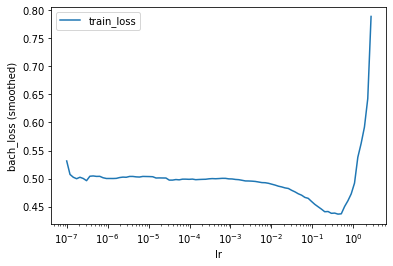

In [138]:
lr_finder = deepHitModel.lr_finder(
        x_train, y_train, batch_size, tolerance=3)
_ = lr_finder.plot()


In [139]:
# we divide the best lr by 3, as usually the LR it reports is higher than appropriate (3 is arbitrary)
best_lr = lr_finder.get_best_lr() / 1

In [140]:
deepHitModel.optimizer.set_lr(best_lr)
epochs = 2000
callbacks = [tt.callbacks.EarlyStopping()]

In [141]:
log = deepHitModel.fit(x_train, y_train, batch_size,
                           epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 0.4256,	val_loss: 0.4498
1:	[0s / 0s],		train_loss: 0.3206,	val_loss: 0.5176
2:	[0s / 0s],		train_loss: 0.2991,	val_loss: 0.5210
3:	[0s / 0s],		train_loss: 0.2485,	val_loss: 0.4312
4:	[0s / 0s],		train_loss: 0.1855,	val_loss: 0.4002
5:	[0s / 0s],		train_loss: 0.2013,	val_loss: 0.3484
6:	[0s / 0s],		train_loss: 0.2133,	val_loss: 0.3049
7:	[0s / 0s],		train_loss: 0.2072,	val_loss: 0.2653
8:	[0s / 0s],		train_loss: 0.1895,	val_loss: 0.2612
9:	[0s / 0s],		train_loss: 0.2127,	val_loss: 0.2666
10:	[0s / 0s],		train_loss: 0.1670,	val_loss: 0.2932
11:	[0s / 0s],		train_loss: 0.2398,	val_loss: 0.3030
12:	[0s / 0s],		train_loss: 0.1947,	val_loss: 0.2624
13:	[0s / 0s],		train_loss: 0.1811,	val_loss: 0.2862
14:	[0s / 0s],		train_loss: 0.2082,	val_loss: 0.3110
15:	[0s / 0s],		train_loss: 0.1624,	val_loss: 0.2828
16:	[0s / 0s],		train_loss: 0.1685,	val_loss: 0.2904
17:	[0s / 0s],		train_loss: 0.1747,	val_loss: 0.2608
18:	[0s / 0s],		train_loss: 0.1818,	val_loss: 0.2725
19:

In [142]:
surv = deepHitModel.interpolate(10).predict_surv_df(x_train)
risk_df = 1 - surv
risk_df.index.name = 'Duration'
risk_df.reset_index(inplace=True)


In [119]:
risk_df


,Duration,0,1,2,3,4,5,6,7,8,...,390,391,392,393,394,395,396,397,398,399
0,0,0.358375,0.728261,0.568807,0.399913,0.726761,0.143414,0.773593,0.695517,0.227164,...,0.516680,0.376170,0.281682,0.680190,0.193926,0.372210,0.152431,0.206786,0.854253,0.299975
1,1,0.358463,0.728303,0.568942,0.400019,0.726803,0.143446,0.773620,0.695576,0.227189,...,0.516818,0.376265,0.281723,0.680255,0.193949,0.372300,0.152449,0.206831,0.854260,0.300041
2,2,0.358550,0.728345,0.569077,0.400126,0.726846,0.143478,0.773648,0.695634,0.227213,...,0.516955,0.376360,0.281765,0.680319,0.193972,0.372390,0.152467,0.206876,0.854267,0.300106
3,3,0.358638,0.728386,0.569212,0.400232,0.726888,0.143510,0.773676,0.695692,0.227238,...,0.517092,0.376455,0.281807,0.680383,0.193994,0.372480,0.152485,0.206921,0.854274,0.300171
4,4,0.358725,0.728428,0.569346,0.400339,0.726930,0.143542,0.773704,0.695751,0.227263,...,0.517230,0.376550,0.281849,0.680447,0.194017,0.372570,0.152503,0.206966,0.854282,0.300237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,86,0.731087,0.880993,0.810405,0.746213,0.880270,0.653130,0.900909,0.866219,0.685366,...,0.790109,0.737450,0.704921,0.859459,0.672897,0.736466,0.657386,0.676913,0.937199,0.710276
87,87,0.792446,0.906116,0.849491,0.802922,0.905517,0.737820,0.921912,0.894196,0.761563,...,0.834472,0.796763,0.775116,0.888807,0.752575,0.796358,0.741433,0.754847,0.950970,0.778019
88,88,0.853805,0.931239,0.888578,0.859631,0.930764,0.822511,0.942914,0.922173,0.837760,...,0.878834,0.856076,0.845312,0.918155,0.832252,0.856250,0.825480,0.832781,0.964741,0.845762
89,89,0.915164,0.956363,0.927664,0.916341,0.956011,0.907202,0.963917,0.950150,0.913957,...,0.923196,0.915389,0.915507,0.947503,0.911930,0.916141,0.909528,0.910715,0.978512,0.913505


In [144]:
# extracting deepHit risk at a specific time
# 10 was caclculated as close to two years in the accompanying manuscript. The index
# should be changed based on the study 
deepHitPredictionsTrain = risk_df.iloc[10, 1:].rank()


Mixture model

We used multi-level mixture model using Mplus software. The codes are available at 
https://www.statmodel.com/usersguide/chapter10.shtml


Due to license restrictions, only M-Plus code is available here and the license may be purchased from the M-Plus website to access the software. 

Example for one-class model

    TITLE:     MEMM
    DATA:      FILE IS edss_array.dat;
    VARIABLE:  NAMES ARE edss1-edss5 t1-t5;
               TSCORES = t1-t5;
               CLASSES = C(1);
               MISSING = ALL(-999);
    ANALYSIS:  ESTIMATOR = MLR;
               TYPE = Random Mixture;
               PROCESSORS = 10;
               !ALGORITHM=INTEGRATION;
               STARTS=1000 500;
               !MCONVERGENCE =0.1;
    SAVEDATA:  FILE=edss_1_Predictions.csv;
               SAVE=CPROB;
    MODEL:
               %OVERALL%
                          I S | edss1-edss5 AT t1-t5;
               I;
               S;
               I S WITH I S;
    edss1;
    edss2;
    edss3;
    edss4;
    edss5;

    %C#1%
    [I-S*1](M1-M2);
    I-S (V1-V2);
    I WITH S (COV1);
    !I;
    !S;
    !edss1;
    !edss2;
    !edss3;
    !edss4;
    !edss5;

    OUTPUT: TECH7;

Example for three-class model


    TITLE:     MEMM
    DATA:      FILE IS edss_array.dat;
    VARIABLE:  NAMES ARE edss1-edss5 t1-t5;
               TSCORES = t1-t5;
               CLASSES = C(3);
               MISSING = ALL(-999);
    ANALYSIS:  ESTIMATOR = MLR;
               TYPE = Random Mixture;
               PROCESSORS = 10;
               !ALGORITHM=INTEGRATION;
               STARTS=1000 500;
               !MCONVERGENCE =0.1;
    SAVEDATA:  FILE=edss_3_Predictions.csv;
               SAVE=CPROB;
    MODEL:
               %OVERALL%
                        I S | edss1-edss5 AT t1-t5;
               I;
               S;
               I S WITH I S;
        edss1;
    edss2;
    edss3;
    edss4;
    edss5;

    %C#1%
    [I-S*1](M1-M2);
    I-S (V1-V2);
    I WITH S (COV1);
    !I;
    !S;

     !edss1;
    !edss2;
    !edss3;
    !edss4;
    !edss5;

    %C#2%
    [I-S*2](M3-M4);
    I-S (V3-V4);
    I WITH S (COV2);
    !I;
    !S;
    !edss1;
    !edss2;
    !edss3;
    !edss4;
    !edss5;

    %C#3%
    [I-S*3](M5-M6);
    I-S (V5-V6);
    I WITH S (COV3);
    !I;
    !S;
    !edss1;
    !edss2;
    !edss3;
    !edss4;
    !edss5;

    OUTPUT: TECH7;

### Ensemble model

Mixture model is included in the original paper accompanying this code, however, is not included here because of M-Plus license restrictions (which cannot be implemented inside a Docker). 

Ensemble model only includes the DeepHit and GBS models

In [99]:
from sksurv import linear_model

In [100]:
cox = linear_model.CoxnetSurvivalAnalysis()

In [ ]:
# GBS prediction 
gbs_ranks_train

deepHitPredictionsTrain




In [180]:
#deep hit prediction
surv_test = deepHitModel.interpolate(10).predict_surv_df(x_test)
risk_df = 1 - surv_test
risk_df.index.name = 'Duration'
risk_df.reset_index(inplace=True)


In [181]:
gbs_predictions_test =np.argsort( gbs.predict( data_x_test)  )


experiments with the mixture model showed the three group is the best way to classify patients, therefore here we use tertiles to divide patients in three groups. 

In [182]:
predictions_train = pd.DataFrame( {'gbs': gbs_ranks_train,
               'deepHit': deepHitPredictionsTrain})

In [183]:
cox.fit(predictions_train, data_y_train)

CoxnetSurvivalAnalysis()

In [185]:
predictions_Test = pd.DataFrame( {'gbs': gbs_predictions_test, 
                                 'deepHit': risk_df.iloc[10, 1:].rank()

                                  })

In [188]:
results = cox.predict( predictions_Test)

In [191]:
data_y_test_df = pd.DataFrame ( data_y_test )

In [ ]:
ph_auc, cph_mean_auc = cumulative_dynamic_auc(
    va_y_train, va_y_test, cph_risk_scores, va_times
)

In [ ]:
resuts